In [ ]:
"""File to confirm if model choice is right and is working fine for similar images."""

In [ ]:
import torch
import numpy as np
from transformers import AutoModel
from transformers import AutoProcessor
from PIL import Image
import os
import matplotlib.pyplot as plt

In [5]:
model = AutoModel.from_pretrained("Marqo/marqo-fashionSigLIP", trust_remote_code=True)
processor = AutoProcessor.from_pretrained('Marqo/marqo-fashionSigLIP', trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

You are using a model of type siglip to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [2]:
embeddings_output_path = r"D:\Fashion recommends\image_embeds\image_embeddings.pt"

In [ ]:
loaded_embeddings = torch.load(embeddings_output_path).to(device)
print(f"\nLoaded {len(loaded_embeddings)} embeddings from {embeddings_output_path}")

In [45]:
from itertools import islice

In [47]:
print(f"Top-level type: {type(loaded_embeddings)}")

Top-level type: <class 'dict'>


In [ ]:
if isinstance(loaded_embeddings, dict):
    print("Top-level keys:")
    for key in islice(loaded_embeddings.keys(), 2):
        print(f"\nKey: {key}")
        try:
            value = loaded_embeddings[key]
            if isinstance(value, dict):
                print(f"Value is a nested dict with {len(value)} keys.")
                for subkey in islice(value.keys(), 2):
                    print(f"  Subkey: {subkey} -> {type(value[subkey])}")
            elif isinstance(value, torch.Tensor):
                print(f"Tensor with shape {value.shape}")
            else:
                print(f"Value type: {type(value)}")
        except Exception as e:
            print(f"Error accessing value: {e}")
else:
    print("The loaded file is not a dict.")

Top-level keys:

Key: 0002732c1a93396ab12789afaea47755af8579d38a4096054cbb05f5463d96b5_1.jpg
Tensor with shape torch.Size([768])

Key: 0002732c1a93396ab12789afaea47755af8579d38a4096054cbb05f5463d96b5_2.jpg
Tensor with shape torch.Size([768])


In [20]:
def get_embedding_for_new_image(image_path_or_pil_image, model, processor, device):
    """
    Generates an embedding for a new input image.
    """
    try:
        if isinstance(image_path_or_pil_image, str):
            img = Image.open(image_path_or_pil_image).convert("RGB")
        elif isinstance(image_path_or_pil_image, Image.Image):
            img = image_path_or_pil_image.convert("RGB")
        else:
            raise ValueError("Input must be a file path or a PIL Image object.")

        processed_input = processor(images=[img], padding='max_length', return_tensors="pt")
        with torch.no_grad():
            image_features = model.get_image_features(processed_input['pixel_values'], normalize=True)
        return image_features.squeeze().cpu()
    except Exception as e:
        print(f"Error processing new image: {e}")
        return None

In [ ]:
new_image_path = r"D:\Fashion recommends\dresses_images\00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_3.jpg"
new_image_embedding = get_embedding_for_new_image(new_image_path, model, processor, device)

In [34]:
num_em = new_image_embedding.numpy()

In [ ]:
similarities = {}
for filename, stored_embedding in loaded_embeddings.items():
    cos_sim = torch.nn.functional.cosine_similarity(new_image_embedding.unsqueeze(0), stored_embedding.unsqueeze(0))
    similarities[filename] = cos_sim.item()

In [ ]:
sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
print("\nTop similar images:")
for i in range(min(7, len(sorted_similarities))):
    print(f"{sorted_similarities[i][0]}: Similarity = {sorted_similarities[i][1]:.4f}")


Top similar images:
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_3.jpg: Similarity = 1.0000
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_1.jpg: Similarity = 0.9599
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_2.jpg: Similarity = 0.9098
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_5.jpg: Similarity = 0.8890
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_6.jpg: Similarity = 0.8724
ab4ee2ad54a4726eba0603958ed915280429f4a40cd16db766ab30fa5517876c_1.jpg: Similarity = 0.8632
ed6b1ccfc27b03f0d3ecb7f4a9e03516c7ea51276f8413fdb455067f1b539755_5.jpg: Similarity = 0.8626


In [ ]:


def plot_image_comparison(original_path, similar_files, image_dir="", top_n=5):
    """
    Plots the original image and top similar images for comparison.
    """
    ncols = min(top_n, len(similar_files)) + 1
    fig, axes = plt.subplots(1, ncols, figsize=(4 * ncols, 4))
    
    if ncols == 1:
        axes = [axes]
    
    try:
        img = Image.open(original_path)
        axes[0].imshow(img)
        axes[0].set_title("Original Image", fontsize=10)
    except Exception as e:
        axes[0].set_title(f"Error loading original\n{str(e)}", color='red')
    axes[0].axis('off')

    for i, (filename, similarity) in enumerate(similar_files[:top_n]):
        ax = axes[i+1]
        try:
            img_path = os.path.join(image_dir, filename) if image_dir else filename
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"Similarity: {similarity:.4f}\n{filename}", fontsize=9)
        except Exception as e:
            ax.set_title(f"Error loading\n{filename}", color='red')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle("Image Similarity Comparison", fontsize=14)
    plt.show()


Top similar images:
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_3.jpg: Similarity = 1.0000
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_1.jpg: Similarity = 0.9599
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_2.jpg: Similarity = 0.9098
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_5.jpg: Similarity = 0.8890
00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_6.jpg: Similarity = 0.8724


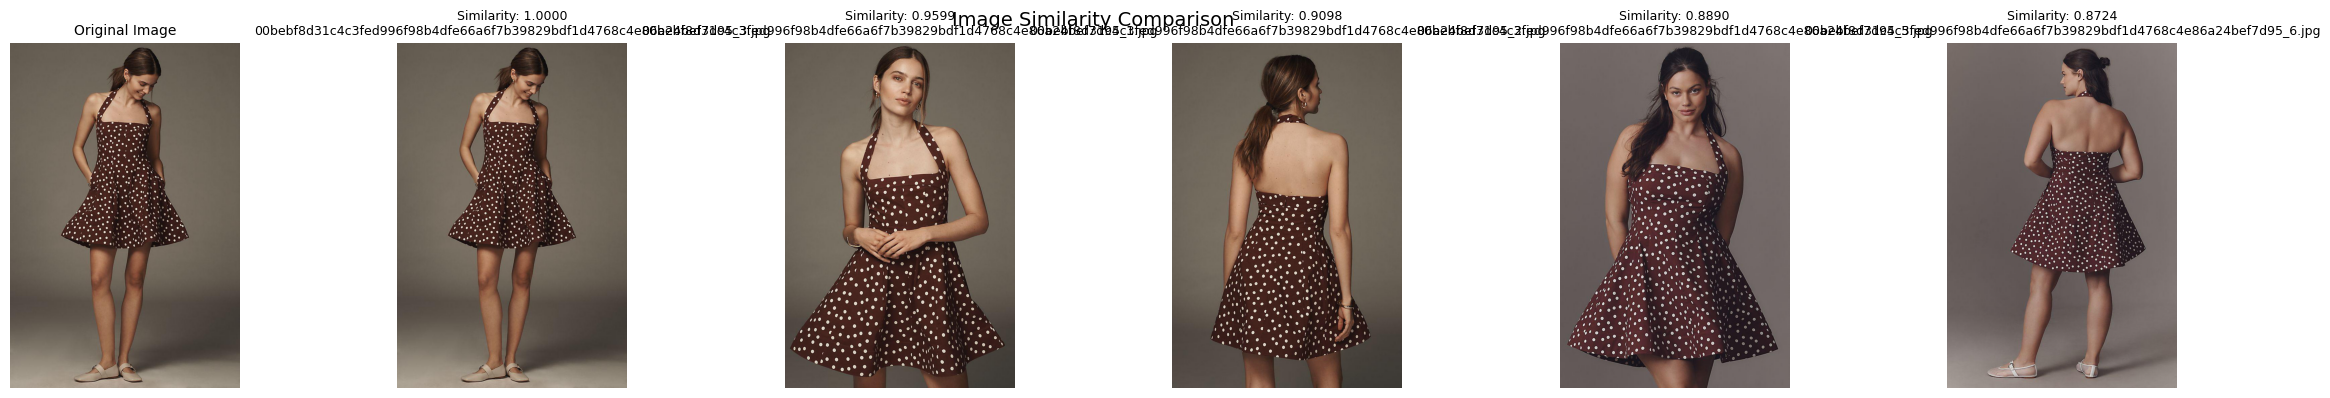

In [ ]:
sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)

print("\nTop similar images:")
for i in range(min(5, len(sorted_similarities))):
    print(f"{sorted_similarities[i][0]}: Similarity = {sorted_similarities[i][1]:.4f}")

plot_image_comparison(
    original_path=r"D:\Fashion recommends\dresses_images\00bebf8d31c4c3fed996f98b4dfe66a6f7b39829bdf1d4768c4e86a24bef7d95_3.jpg",
    similar_files=sorted_similarities[:5],
    image_dir=r"D:\\Fashion recommends\\dresses_images"
)